In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tqdm import tqdm
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.saving import load_model

In [2]:
def random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)

In [3]:
img_size = 128

In [4]:
def data_loading(path):
    cxrs = []
    for i in tqdm(range(len(os.listdir(path)))):
        image = os.listdir(path)[i]
        cxr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
        cxr = cv2.resize(cxr, (img_size, img_size))
        cxrs.append(cxr)
    return np.array(cxrs, dtype=int)

In [5]:
train_normal = data_loading('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL')
train_pneumonia = data_loading('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')

print(np.shape(train_normal))
print(np.shape(train_pneumonia))

100%|██████████| 3875/3875 [00:58<00:00, 66.07it/s]


(1341, 128, 128)
(3875, 128, 128)


In [6]:
val_normal = data_loading('/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL')
val_pneumonia = data_loading('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA')

train_normal = np.concatenate((train_normal, val_normal), axis=0)
train_pneumonia = np.concatenate((train_pneumonia, val_pneumonia), axis=0)

print(np.shape(train_normal))
print(np.shape(train_pneumonia))

100%|██████████| 8/8 [00:00<00:00, 111.31it/s]


(1349, 128, 128)
(3883, 128, 128)


In [7]:
test_normal = data_loading('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL')
test_pneumonia = data_loading('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA')

print(np.shape(test_normal))
print(np.shape(test_pneumonia))

100%|██████████| 390/390 [00:04<00:00, 94.39it/s]

(234, 128, 128)
(390, 128, 128)


In [8]:
x_train_cxr = np.concatenate((train_normal, train_pneumonia), axis=0)
x_test_cxr = np.concatenate((test_normal, test_pneumonia), axis=0)

y_train = np.array([0] * np.shape(train_normal)[0] + [1] * np.shape(train_pneumonia)[0], dtype=int)
y_test = np.array([0] * np.shape(test_normal)[0] + [1] * np.shape(test_pneumonia)[0], dtype=int)

print(np.shape(x_train_cxr))
print(np.shape(y_train))
print(np.shape(x_test_cxr))
print(np.shape(y_test))

(5232, 128, 128)
(5232,)
(624, 128, 128)
(624,)


In [9]:
index_list = []
for i in range(np.shape(x_train_cxr)[0]):
    index_list.append(i)
random_seed(42)
random.shuffle(index_list)

x_train_shuffle = np.zeros(np.shape(x_train_cxr))
y_train_shuffle = np.zeros(np.shape(y_train))
for i in tqdm(range(len(index_list))):
    index = index_list[i]
    x_train_shuffle[i] = x_train_cxr[index]
    y_train_shuffle[i] = y_train[index]

x_train_cxr = x_train_shuffle
y_train = y_train_shuffle

del x_train_shuffle
del y_train_shuffle

print(np.shape(x_train_cxr))
print(np.shape(y_train))
print(np.shape(x_test_cxr))
print(np.shape(y_test))

100%|██████████| 5232/5232 [00:00<00:00, 9258.77it/s]

(5232, 128, 128)
(5232,)
(624, 128, 128)
(624,)


In [10]:
x_train_cxr = x_train_cxr.reshape(-1, img_size, img_size, 1) / 255.0
x_test_cxr = x_test_cxr.reshape(-1, img_size, img_size, 1) / 255.0

In [11]:
random_seed(42)

datagen = ImageDataGenerator(
    zoom_range=0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    horizontal_flip=False
)

datagen.fit(x_train_cxr, seed=42)

batch_size = np.shape(x_train_cxr)[0]
x_train_cxr = next(datagen.flow(x_train_cxr, batch_size=batch_size, shuffle=False, seed=42))

In [12]:
r2unet_ch0 = load_model('/kaggle/input/unet/keras/default/14/R2Unet.h5')
r2unet_ch1 = load_model('/kaggle/input/unet/keras/default/15/R2Unet.h5')

x_train_mask_ch0 = r2unet_ch0.predict(x_train_cxr, verbose=True) >= 0.5
x_test_mask_ch0 = r2unet_ch0.predict(x_test_cxr, verbose=True) >= 0.5
x_train_mask_ch1 = r2unet_ch1.predict(x_train_cxr, verbose=True) >= 0.5
x_test_mask_ch1 = r2unet_ch1.predict(x_test_cxr, verbose=True) >= 0.5

print(np.shape(x_train_mask_ch0))
print(np.shape(x_test_mask_ch0))

x_train_segment_ch0 = x_train_cxr * x_train_mask_ch0
x_test_segment_ch0 = x_test_cxr * x_test_mask_ch0
x_train_segment_ch1 = x_train_cxr * x_train_mask_ch1
x_test_segment_ch1 = x_test_cxr * x_test_mask_ch1

print(np.shape(x_train_segment_ch0))
print(np.shape(x_test_segment_ch0))

164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
(5232, 128, 128, 1)
(624, 128, 128, 1)
(5232, 128, 128, 1)
(624, 128, 128, 1)


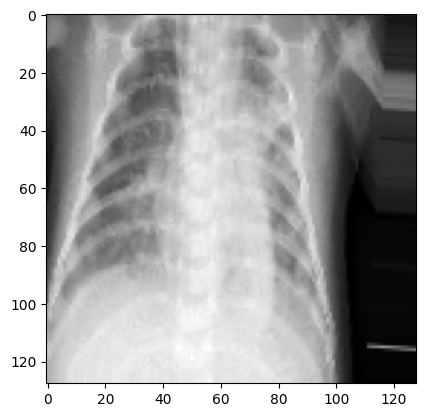

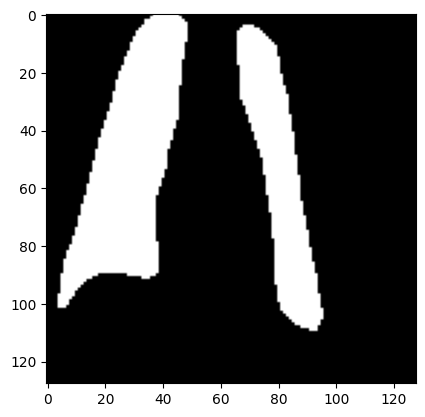

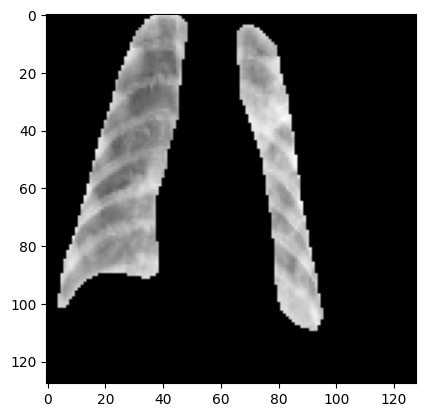

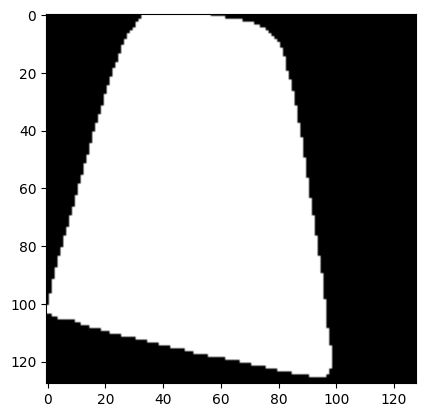

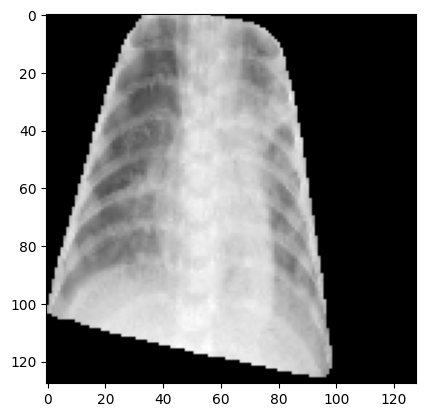

In [13]:
idx = 0
plt.imshow(x_train_cxr[idx], cmap='gray')
plt.show()
plt.imshow(x_train_mask_ch0[idx], cmap='gray')
plt.show()
plt.imshow(x_train_segment_ch0[idx], cmap='gray')
plt.show()
plt.imshow(x_train_mask_ch1[idx], cmap='gray')
plt.show()
plt.imshow(x_train_segment_ch1[idx], cmap='gray')
plt.show()

In [14]:
save_path = '/kaggle/working/chest-xray/train'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'images'), x_train_cxr)
np.save(os.path.join(save_path, 'labels'), y_train)

save_path = '/kaggle/working/chest-xray/test'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'images'), x_test_cxr)
np.save(os.path.join(save_path, 'labels'), y_test)

In [15]:
save_path = '/kaggle/working/segment/train'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'images'), x_train_segment_ch0)
np.save(os.path.join(save_path, 'labels'), y_train)

save_path = '/kaggle/working/segment/test'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'images'), x_test_segment_ch0)
np.save(os.path.join(save_path, 'labels'), y_test)

In [16]:
save_path = '/kaggle/working/segment_with_convexhull/train'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'images'), x_train_segment_ch1)
np.save(os.path.join(save_path, 'labels'), y_train)

save_path = '/kaggle/working/segment_with_convexhull/test'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'images'), x_test_segment_ch1)
np.save(os.path.join(save_path, 'labels'), y_test)

In [17]:
# !rm -rf /kaggle/working/*